In [15]:
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
import s3fs
import time
import boto3, os
from urllib.parse import urlparse

sess = sagemaker.Session()
run_prefix = str(int(round(time.time() * 1000)))
role = get_execution_role()

In [5]:
#read csv from s3 bucket

df = pd.read_csv('s3://nlp-awesome-sauce/dataset/lowtrain.csv', usecols = [3])
#low_df_test = pd.read_csv('s3://nlp-awesome-sauce/dataset/lowtrain.csv',names=["rating", "title", "review"])
#low_df_test[low_df_test['review'].str.contains('vacuum')]
df.head() 

,"This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star reviews must have been written by Ms. Haddon's family and friends--or perhaps, by herself! I can't imagine anyone reading the whole thing--I spent an evening with the book and a friend and we were in hysterics reading bits and pieces of it to one another. It is most definitely bad enough to be entered into some kind of a ""worst book"" contest. I can't believe Amazon even sells this kind of thing. Maybe I can offer them my 8th grade term paper on ""To Kill a Mockingbird""--a book I am quite sure Ms. Haddon never heard of. Anyway, unless you are in a mood to send a book to someone as a joke---stay far, far away from this one!"
0,A complete waste of time. Typographical errors...
1,I guess you have to be a romance novel lover f...
2,I feel I have to write to keep others from was...
3,It's glaringly obvious that all of the glowing...
4,sizes are much smaller than what is recomended...


In [31]:
df.to_csv("reviewsOnly2.csv", header=False)
!aws s3 cp reviewsOnly2.csv s3://nlp-awesome-sauce/dataset/ntm/Jan30/

upload: ./reviewsOnly2.csv to s3://nlp-awesome-sauce/dataset/ntm/Jan30/reviewsOnly2.csv


In [35]:
df = df.sample(frac=.5)

In [36]:
data = df.to_numpy().flatten()

In [37]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import re
token_pattern = re.compile(r"(?u)\b\w\w+\b")
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if len(t) >= 2 and re.match("[a-z].*",t) 
                and re.match(token_pattern, t)]

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [38]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
vocab_size = 2000
print('Tokenizing and counting, this may take a few minutes...')
start_time = time.time()
print("Start. {}".format(start_time))
vectorizer = CountVectorizer(input='content', analyzer='word', stop_words='english',
                             tokenizer=LemmaTokenizer(), max_features=vocab_size, max_df=0.95, min_df=2)
vectors = vectorizer.fit_transform(data)
vocab_list = vectorizer.get_feature_names()
print('vocab size:', len(vocab_list))

# random shuffle
idx = np.arange(vectors.shape[0])
np.random.shuffle(idx)
vectors = vectors[idx]

print('Done. Time elapsed: {:.2f}s'.format(time.time() - start_time))

Tokenizing and counting, this may take a few minutes...
Start. 1580403470.6402438


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


vocab size: 2000
Done. Time elapsed: 500.68s


In [39]:
import scipy.sparse as sparse
vectors = sparse.csr_matrix(vectors, dtype=np.float32)
print(type(vectors), vectors.dtype)

<class 'scipy.sparse.csr.csr_matrix'> float32


In [40]:
n_train = int(0.8 * vectors.shape[0])

# split train and test
train_vectors = vectors[:n_train, :]
test_vectors = vectors[n_train:, :]

# further split test set into validation set (val_vectors) and test  set (test_vectors)
n_test = test_vectors.shape[0]
val_vectors = test_vectors[:n_test//2, :]
test_vectors = test_vectors[n_test//2:, :]

print(train_vectors.shape, test_vectors.shape, val_vectors.shape)

(360000, 2000) (45000, 2000) (45000, 2000)


In [52]:
import os
from sagemaker import get_execution_role

role = get_execution_role()

bucket = 'nlp-awesome-sauce'
prefix = 'ntm'

train_prefix = os.path.join(prefix, 'train', 'Jan30')
val_prefix = os.path.join(prefix, 'val', 'Jan30')
test_prefix = os.path.join(prefix, 'test', 'Jan30')
output_prefix = os.path.join(prefix, 'output', 'Jan30')

s3_train_data = os.path.join('s3://', bucket, train_prefix)
s3_val_data = os.path.join('s3://', bucket, val_prefix)
s3_test_data = os.path.join('s3://', bucket, test_prefix)
output_path = os.path.join('s3://', bucket, output_prefix)
print('Training set location', s3_train_data)
print('Validation set location', s3_val_data)
print('Trained model will be saved at', output_path)

Training set location s3://nlp-awesome-sauce/ntm/train/Jan30
Validation set location s3://nlp-awesome-sauce/ntm/val/Jan30
Trained model will be saved at s3://nlp-awesome-sauce/ntm/output/Jan30


In [42]:
def split_convert_upload(sparray, bucket, prefix, fname_template='data_part{}.pbr', n_parts=2):
    import io
    import sagemaker.amazon.common as smac
    
    chunk_size = sparray.shape[0]// n_parts
    for i in range(n_parts):

        # Calculate start and end indices
        start = i*chunk_size
        end = (i+1)*chunk_size
        if i+1 == n_parts:
            end = sparray.shape[0]
        
        # Convert to record protobuf
        buf = io.BytesIO()
        smac.write_spmatrix_to_sparse_tensor(array=sparray[start:end], file=buf, labels=None)
        buf.seek(0)
        
        # Upload to s3 location specified by bucket and prefix
        fname = os.path.join(prefix, fname_template.format(i))
        boto3.resource('s3').Bucket(bucket).Object(fname).upload_fileobj(buf)
        print('Uploaded data to s3://{}'.format(os.path.join(bucket, fname)))

In [53]:
split_convert_upload(train_vectors, bucket=bucket, prefix=train_prefix, fname_template='train_part{}.pbr', n_parts=8)

Uploaded data to s3://nlp-awesome-sauce/ntm/train/Jan30/train_part0.pbr
Uploaded data to s3://nlp-awesome-sauce/ntm/train/Jan30/train_part1.pbr
Uploaded data to s3://nlp-awesome-sauce/ntm/train/Jan30/train_part2.pbr
Uploaded data to s3://nlp-awesome-sauce/ntm/train/Jan30/train_part3.pbr
Uploaded data to s3://nlp-awesome-sauce/ntm/train/Jan30/train_part4.pbr
Uploaded data to s3://nlp-awesome-sauce/ntm/train/Jan30/train_part5.pbr
Uploaded data to s3://nlp-awesome-sauce/ntm/train/Jan30/train_part6.pbr
Uploaded data to s3://nlp-awesome-sauce/ntm/train/Jan30/train_part7.pbr


In [54]:
split_convert_upload(val_vectors, bucket=bucket, prefix=val_prefix, fname_template='val_part{}.pbr', n_parts=1)

Uploaded data to s3://nlp-awesome-sauce/ntm/val/Jan30/val_part0.pbr


In [55]:
split_convert_upload(test_vectors, bucket=bucket, prefix=test_prefix, fname_template='test_part{}.pbr', n_parts=1)

Uploaded data to s3://nlp-awesome-sauce/ntm/test/Jan30/test_part0.pbr


In [82]:
containers = {'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/ntm:latest'}
ntm = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                    role, 
                                    train_instance_count=4, 
                                    train_instance_type='ml.c4.xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sess)
num_topics = 6
ntm.set_hyperparameters(num_topics=num_topics, feature_dim=vocab_size, mini_batch_size=128, 
                        epochs=100, num_patience_epochs=5, tolerance=0.001)

In [83]:
from sagemaker.session import s3_input
s3_train = s3_input(s3_train_data, distribution='ShardedByS3Key') 


In [84]:
ntm.fit({'train': s3_train, 'test': s3_val_data})

2020-01-30 19:16:39 Starting - Starting the training job...
2020-01-30 19:16:40 Starting - Launching requested ML instances......
2020-01-30 19:17:47 Starting - Preparing the instances for training.........
2020-01-30 19:19:24 Downloading - Downloading input data......
2020-01-30 19:20:37 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Docker entrypoint called with argument(s): train
/opt/amazon/lib/python2.7/site-packages/pandas/util/nosetester.py:13: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing import nosetester
[01/30/2020 19:20:53 INFO 140681808238400] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_patience_epochs': u'3', u'clip_gradient': u'Inf', u'encoder_layers': u'auto', u'optimizer': u'adadelta', u'_kvstore': u'auto_gpu', u'rescale_gradient': u'1.0', u'_tuning_objective_metric': u'', u

#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Records Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Batches Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Total Records Seen": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Max Records Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Reset Count": {"count": 1, "max": 0, "sum": 0.0, "min": 0}}, "EndTime": 1580412059.990168, "Dimensions": {"Host": "algo-3", "Meta": "init_train_data_iter", "Operation": "training", "Algorithm": "AWS/NTM"}, "StartTime": 1580412059.990132}

[2020-01-30 19:20:59.991] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 0, "duration": 1046, "num_examples": 1, "num_bytes": 20876}
[01/30/2020 19:20:59 INFO 140681808238400] 
[01/30/2020 19:20:59 INFO 140681808238400] # Starting tra

[2020-01-30 19:21:38.366] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 5, "duration": 19509, "num_examples": 704, "num_bytes": 14353168}
[01/30/2020 19:21:38 INFO 140681808238400] # Finished training epoch 2 on 90000 examples from 704 batches, each of size 128.
[01/30/2020 19:21:38 INFO 140681808238400] Metrics for Training:
[01/30/2020 19:21:38 INFO 140681808238400] Loss (name: value) total: 6.60909104838
[01/30/2020 19:21:38 INFO 140681808238400] Loss (name: value) kld: 0.0979281657558
[01/30/2020 19:21:38 INFO 140681808238400] Loss (name: value) recons: 6.51116288267
[01/30/2020 19:21:38 INFO 140681808238400] Loss (name: value) logppx: 6.60909104838
[01/30/2020 19:21:38 INFO 140681808238400] #quality_metric: host=algo-3, epoch=2, train total_loss <loss>=6.60909104838
[01/30/2020 19:21:38 INFO 140681808238400] Timing: train: 19.51s, val: 0.00s, epoch: 19.52s
[01/30/2020 19:21:38 INFO 140681808238400] #progress_metric: host=algo-3, completed 2 %

[2020-01-30 19:21:57.398] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 8, "duration": 19024, "num_examples": 704, "num_bytes": 14353168}
[01/30/2020 19:21:57 INFO 140681808238400] # Finished training epoch 3 on 90000 examples from 704 batches, each of size 128.
[01/30/2020 19:21:57 INFO 140681808238400] Metrics for Training:
[01/30/2020 19:21:57 INFO 140681808238400] Loss (name: value) total: 6.59232666902
[01/30/2020 19:21:57 INFO 140681808238400] Loss (name: value) kld: 0.110576747484
[01/30/2020 19:21:57 INFO 140681808238400] Loss (name: value) recons: 6.4817499123
[01/30/2020 19:21:57 INFO 140681808238400] Loss (name: value) logppx: 6.59232666902
[01/30/2020 19:21:57 INFO 140681808238400] #quality_metric: host=algo-3, epoch=3, train total_loss <loss>=6.59232666902
[01/30/2020 19:21:57 INFO 140681808238400] Timing: train: 19.03s, val: 0.00s, epoch: 19.03s
[01/30/2020 19:21:57 INFO 140681808238400] #progress_metric: host=algo-3, completed 3 % o

[2020-01-30 19:22:16.220] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 11, "duration": 18816, "num_examples": 704, "num_bytes": 14353168}
[01/30/2020 19:22:16 INFO 140681808238400] # Finished training epoch 4 on 90000 examples from 704 batches, each of size 128.
[01/30/2020 19:22:16 INFO 140681808238400] Metrics for Training:
[01/30/2020 19:22:16 INFO 140681808238400] Loss (name: value) total: 6.58002328492
[01/30/2020 19:22:16 INFO 140681808238400] Loss (name: value) kld: 0.12058165151
[01/30/2020 19:22:16 INFO 140681808238400] Loss (name: value) recons: 6.45944163432
[01/30/2020 19:22:16 INFO 140681808238400] Loss (name: value) logppx: 6.58002328492
[01/30/2020 19:22:16 INFO 140681808238400] #quality_metric: host=algo-3, epoch=4, train total_loss <loss>=6.58002328492
[01/30/2020 19:22:16 INFO 140681808238400] Timing: train: 18.82s, val: 0.00s, epoch: 18.82s
[01/30/2020 19:22:16 INFO 140681808238400] #progress_metric: host=algo-3, completed 4 % 

[2020-01-30 19:22:35.164] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 14, "duration": 18936, "num_examples": 704, "num_bytes": 14353168}
[01/30/2020 19:22:35 INFO 140681808238400] # Finished training epoch 5 on 90000 examples from 704 batches, each of size 128.
[01/30/2020 19:22:35 INFO 140681808238400] Metrics for Training:
[01/30/2020 19:22:35 INFO 140681808238400] Loss (name: value) total: 6.56274974507
[01/30/2020 19:22:35 INFO 140681808238400] Loss (name: value) kld: 0.137503906227
[01/30/2020 19:22:35 INFO 140681808238400] Loss (name: value) recons: 6.42524583892
[01/30/2020 19:22:35 INFO 140681808238400] Loss (name: value) logppx: 6.56274974507
[01/30/2020 19:22:35 INFO 140681808238400] #quality_metric: host=algo-3, epoch=5, train total_loss <loss>=6.56274974507
[01/30/2020 19:22:35 INFO 140681808238400] Timing: train: 18.94s, val: 0.00s, epoch: 18.94s
[01/30/2020 19:22:35 INFO 140681808238400] #progress_metric: host=algo-3, completed 5 %

[2020-01-30 19:22:53.934] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 17, "duration": 18762, "num_examples": 704, "num_bytes": 14353168}
[01/30/2020 19:22:53 INFO 140681808238400] # Finished training epoch 6 on 90000 examples from 704 batches, each of size 128.
[01/30/2020 19:22:53 INFO 140681808238400] Metrics for Training:
[01/30/2020 19:22:53 INFO 140681808238400] Loss (name: value) total: 6.55315546285
[01/30/2020 19:22:53 INFO 140681808238400] Loss (name: value) kld: 0.145836145937
[01/30/2020 19:22:53 INFO 140681808238400] Loss (name: value) recons: 6.40731931046
[01/30/2020 19:22:53 INFO 140681808238400] Loss (name: value) logppx: 6.55315546285
[01/30/2020 19:22:53 INFO 140681808238400] #quality_metric: host=algo-3, epoch=6, train total_loss <loss>=6.55315546285
[01/30/2020 19:22:53 INFO 140681808238400] patience losses:[6.697994310408831, 6.6090910483829, 6.592326669022441, 6.580023284916851, 6.562749745070257] min patience loss:6.562749

[2020-01-30 19:23:12.943] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 20, "duration": 19003, "num_examples": 704, "num_bytes": 14353168}
[01/30/2020 19:23:12 INFO 140681808238400] # Finished training epoch 7 on 90000 examples from 704 batches, each of size 128.
[01/30/2020 19:23:12 INFO 140681808238400] Metrics for Training:
[01/30/2020 19:23:12 INFO 140681808238400] Loss (name: value) total: 6.54622289183
[01/30/2020 19:23:12 INFO 140681808238400] Loss (name: value) kld: 0.152880254466
[01/30/2020 19:23:12 INFO 140681808238400] Loss (name: value) recons: 6.39334264254
[01/30/2020 19:23:12 INFO 140681808238400] Loss (name: value) logppx: 6.54622289183
[01/30/2020 19:23:12 INFO 140681808238400] #quality_metric: host=algo-3, epoch=7, train total_loss <loss>=6.54622289183
[01/30/2020 19:23:12 INFO 140681808238400] patience losses:[6.6090910483829, 6.592326669022441, 6.580023284916851, 6.562749745070257, 6.553155462850224] min patience loss:6.553155

[2020-01-30 19:23:31.744] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 23, "duration": 18796, "num_examples": 704, "num_bytes": 14353168}
[01/30/2020 19:23:31 INFO 140681808238400] # Finished training epoch 8 on 90000 examples from 704 batches, each of size 128.
[01/30/2020 19:23:31 INFO 140681808238400] Metrics for Training:
[01/30/2020 19:23:31 INFO 140681808238400] Loss (name: value) total: 6.54218002561
[01/30/2020 19:23:31 INFO 140681808238400] Loss (name: value) kld: 0.162201026537
[01/30/2020 19:23:31 INFO 140681808238400] Loss (name: value) recons: 6.37997899306
[01/30/2020 19:23:31 INFO 140681808238400] Loss (name: value) logppx: 6.54218002561
[01/30/2020 19:23:31 INFO 140681808238400] #quality_metric: host=algo-3, epoch=8, train total_loss <loss>=6.54218002561
[01/30/2020 19:23:31 INFO 140681808238400] patience losses:[6.592326669022441, 6.580023284916851, 6.562749745070257, 6.553155462850224, 6.546222891827876] min patience loss:6.5462

[2020-01-30 19:23:50.338] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 26, "duration": 18589, "num_examples": 704, "num_bytes": 14353168}
[01/30/2020 19:23:50 INFO 140681808238400] # Finished training epoch 9 on 90000 examples from 704 batches, each of size 128.
[01/30/2020 19:23:50 INFO 140681808238400] Metrics for Training:
[01/30/2020 19:23:50 INFO 140681808238400] Loss (name: value) total: 6.53950045478
[01/30/2020 19:23:50 INFO 140681808238400] Loss (name: value) kld: 0.166909190797
[01/30/2020 19:23:50 INFO 140681808238400] Loss (name: value) recons: 6.37259126497
[01/30/2020 19:23:50 INFO 140681808238400] Loss (name: value) logppx: 6.53950045478
[01/30/2020 19:23:50 INFO 140681808238400] #quality_metric: host=algo-3, epoch=9, train total_loss <loss>=6.53950045478
[01/30/2020 19:23:50 INFO 140681808238400] patience losses:[6.580023284916851, 6.562749745070257, 6.553155462850224, 6.546222891827876, 6.542180025611412] min patience loss:6.5421

[2020-01-30 19:24:09.098] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 29, "duration": 18754, "num_examples": 704, "num_bytes": 14353168}
[01/30/2020 19:24:09 INFO 140681808238400] # Finished training epoch 10 on 90000 examples from 704 batches, each of size 128.
[01/30/2020 19:24:09 INFO 140681808238400] Metrics for Training:
[01/30/2020 19:24:09 INFO 140681808238400] Loss (name: value) total: 6.5360143078
[01/30/2020 19:24:09 INFO 140681808238400] Loss (name: value) kld: 0.170863418517
[01/30/2020 19:24:09 INFO 140681808238400] Loss (name: value) recons: 6.36515087965
[01/30/2020 19:24:09 INFO 140681808238400] Loss (name: value) logppx: 6.5360143078
[01/30/2020 19:24:09 INFO 140681808238400] #quality_metric: host=algo-3, epoch=10, train total_loss <loss>=6.5360143078
[01/30/2020 19:24:09 INFO 140681808238400] patience losses:[6.562749745070257, 6.553155462850224, 6.546222891827876, 6.542180025611412, 6.539500454779375] min patience loss:6.53950

[2020-01-30 19:24:28.345] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 32, "duration": 19239, "num_examples": 704, "num_bytes": 14353168}
[01/30/2020 19:24:28 INFO 140681808238400] # Finished training epoch 11 on 90000 examples from 704 batches, each of size 128.
[01/30/2020 19:24:28 INFO 140681808238400] Metrics for Training:
[01/30/2020 19:24:28 INFO 140681808238400] Loss (name: value) total: 6.53478485541
[01/30/2020 19:24:28 INFO 140681808238400] Loss (name: value) kld: 0.172996445376
[01/30/2020 19:24:28 INFO 140681808238400] Loss (name: value) recons: 6.3617884029
[01/30/2020 19:24:28 INFO 140681808238400] Loss (name: value) logppx: 6.53478485541
[01/30/2020 19:24:28 INFO 140681808238400] #quality_metric: host=algo-3, epoch=11, train total_loss <loss>=6.53478485541
[01/30/2020 19:24:28 INFO 140681808238400] patience losses:[6.553155462850224, 6.546222891827876, 6.542180025611412, 6.539500454779375, 6.53601430779831] min patience loss:6.5360

[2020-01-30 19:24:47.513] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 35, "duration": 19162, "num_examples": 704, "num_bytes": 14353168}
[01/30/2020 19:24:47 INFO 140681808238400] # Finished training epoch 12 on 90000 examples from 704 batches, each of size 128.
[01/30/2020 19:24:47 INFO 140681808238400] Metrics for Training:
[01/30/2020 19:24:47 INFO 140681808238400] Loss (name: value) total: 6.53261303936
[01/30/2020 19:24:47 INFO 140681808238400] Loss (name: value) kld: 0.17268421906
[01/30/2020 19:24:47 INFO 140681808238400] Loss (name: value) recons: 6.35992882155
[01/30/2020 19:24:47 INFO 140681808238400] Loss (name: value) logppx: 6.53261303936
[01/30/2020 19:24:47 INFO 140681808238400] #quality_metric: host=algo-3, epoch=12, train total_loss <loss>=6.53261303936
[01/30/2020 19:24:47 INFO 140681808238400] patience losses:[6.546222891827876, 6.542180025611412, 6.539500454779375, 6.53601430779831, 6.534784855405715] min patience loss:6.5347

[2020-01-30 19:25:06.480] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 38, "duration": 18960, "num_examples": 704, "num_bytes": 14353168}
[01/30/2020 19:25:06 INFO 140681808238400] # Finished training epoch 13 on 90000 examples from 704 batches, each of size 128.
[01/30/2020 19:25:06 INFO 140681808238400] Metrics for Training:
[01/30/2020 19:25:06 INFO 140681808238400] Loss (name: value) total: 6.53366913155
[01/30/2020 19:25:06 INFO 140681808238400] Loss (name: value) kld: 0.17345167715
[01/30/2020 19:25:06 INFO 140681808238400] Loss (name: value) recons: 6.36021745603
[01/30/2020 19:25:06 INFO 140681808238400] Loss (name: value) logppx: 6.53366913155
[01/30/2020 19:25:06 INFO 140681808238400] #quality_metric: host=algo-3, epoch=13, train total_loss <loss>=6.53366913155
[01/30/2020 19:25:06 INFO 140681808238400] patience losses:[6.542180025611412, 6.539500454779375, 6.53601430779831, 6.534784855405715, 6.532613039355386] min patience loss:6.5326

[2020-01-30 19:25:25.168] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 41, "duration": 18684, "num_examples": 704, "num_bytes": 14353168}
[01/30/2020 19:25:25 INFO 140681808238400] # Finished training epoch 14 on 90000 examples from 704 batches, each of size 128.
[01/30/2020 19:25:25 INFO 140681808238400] Metrics for Training:
[01/30/2020 19:25:25 INFO 140681808238400] Loss (name: value) total: 6.5326669913
[01/30/2020 19:25:25 INFO 140681808238400] Loss (name: value) kld: 0.172981168088
[01/30/2020 19:25:25 INFO 140681808238400] Loss (name: value) recons: 6.35968582908
[01/30/2020 19:25:25 INFO 140681808238400] Loss (name: value) logppx: 6.5326669913
[01/30/2020 19:25:25 INFO 140681808238400] #quality_metric: host=algo-3, epoch=14, train total_loss <loss>=6.5326669913
[01/30/2020 19:25:25 INFO 140681808238400] patience losses:[6.539500454779375, 6.53601430779831, 6.534784855405715, 6.532613039355386, 6.533669131553986] min patience loss:6.532613

[2020-01-30 19:25:43.989] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 44, "duration": 18817, "num_examples": 704, "num_bytes": 14353168}
[01/30/2020 19:25:43 INFO 140681808238400] # Finished training epoch 15 on 90000 examples from 704 batches, each of size 128.
[01/30/2020 19:25:43 INFO 140681808238400] Metrics for Training:
[01/30/2020 19:25:43 INFO 140681808238400] Loss (name: value) total: 6.5332813489
[01/30/2020 19:25:43 INFO 140681808238400] Loss (name: value) kld: 0.173529714312
[01/30/2020 19:25:43 INFO 140681808238400] Loss (name: value) recons: 6.35975163354
[01/30/2020 19:25:43 INFO 140681808238400] Loss (name: value) logppx: 6.5332813489
[01/30/2020 19:25:43 INFO 140681808238400] #quality_metric: host=algo-3, epoch=15, train total_loss <loss>=6.5332813489
[01/30/2020 19:25:43 INFO 140681808238400] patience losses:[6.53601430779831, 6.534784855405715, 6.532613039355386, 6.533669131553986, 6.5326669912954625] min patience loss:6.53261

[2020-01-30 19:26:03.035] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 47, "duration": 19044, "num_examples": 704, "num_bytes": 14353168}
[01/30/2020 19:26:03 INFO 140681808238400] # Finished training epoch 16 on 90000 examples from 704 batches, each of size 128.
[01/30/2020 19:26:03 INFO 140681808238400] Metrics for Training:
[01/30/2020 19:26:03 INFO 140681808238400] Loss (name: value) total: 6.53197493108
[01/30/2020 19:26:03 INFO 140681808238400] Loss (name: value) kld: 0.172925156864
[01/30/2020 19:26:03 INFO 140681808238400] Loss (name: value) recons: 6.35904976692
[01/30/2020 19:26:03 INFO 140681808238400] Loss (name: value) logppx: 6.53197493108
[01/30/2020 19:26:03 INFO 140681808238400] #quality_metric: host=algo-3, epoch=16, train total_loss <loss>=6.53197493108
[01/30/2020 19:26:03 INFO 140681808238400] patience losses:[6.534784855405715, 6.532613039355386, 6.533669131553986, 6.5326669912954625, 6.533281348899684] min patience loss:6.5

[2020-01-30 19:26:23.181] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 50, "duration": 18977, "num_examples": 704, "num_bytes": 14346352}
[01/30/2020 19:26:23 INFO 140488592414528] # Finished training epoch 17 on 90000 examples from 704 batches, each of size 128.
[01/30/2020 19:26:23 INFO 140488592414528] Metrics for Training:
[01/30/2020 19:26:23 INFO 140488592414528] Loss (name: value) total: 6.53473567057
[01/30/2020 19:26:23 INFO 140488592414528] Loss (name: value) kld: 0.173468333034
[01/30/2020 19:26:23 INFO 140488592414528] Loss (name: value) recons: 6.36126732742
[01/30/2020 19:26:23 INFO 140488592414528] Loss (name: value) logppx: 6.53473567057
[01/30/2020 19:26:23 INFO 140488592414528] #quality_metric: host=algo-1, epoch=17, train total_loss <loss>=6.53473567057
[01/30/2020 19:26:23 INFO 140488592414528] patience losses:[6.534692618318579, 6.534178063950756, 6.535610641268167, 6.534901747480035, 6.5345807141539725] min patience loss:6.5

[2020-01-30 19:26:46.566] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 53, "duration": 15717, "num_examples": 704, "num_bytes": 14356152}
[01/30/2020 19:26:46 INFO 140009804048192] # Finished training epoch 18 on 90000 examples from 704 batches, each of size 128.
[01/30/2020 19:26:46 INFO 140009804048192] Metrics for Training:
[01/30/2020 19:26:46 INFO 140009804048192] Loss (name: value) total: 6.52761905268
[01/30/2020 19:26:46 INFO 140009804048192] Loss (name: value) kld: 0.173219291118
[01/30/2020 19:26:46 INFO 140009804048192] Loss (name: value) recons: 6.3543997683
[01/30/2020 19:26:46 INFO 140009804048192] Loss (name: value) logppx: 6.52761905268
[01/30/2020 19:26:46 INFO 140009804048192] #quality_metric: host=algo-4, epoch=18, train total_loss <loss>=6.52761905268
[01/30/2020 19:26:46 INFO 140009804048192] patience losses:[6.532280548052355, 6.532566936347973, 6.531767302616076, 6.532408427193084, 6.532327910631218] min patience loss:6.531

[2020-01-30 19:27:14.383] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 59, "duration": 13821, "num_examples": 704, "num_bytes": 14356152}
[01/30/2020 19:27:14 INFO 140009804048192] # Finished training epoch 20 on 90000 examples from 704 batches, each of size 128.
[01/30/2020 19:27:14 INFO 140009804048192] Metrics for Training:
[01/30/2020 19:27:14 INFO 140009804048192] Loss (name: value) total: 6.52549211478
[01/30/2020 19:27:14 INFO 140009804048192] Loss (name: value) kld: 0.174020669611
[01/30/2020 19:27:14 INFO 140009804048192] Loss (name: value) recons: 6.35147145289
[01/30/2020 19:27:14 INFO 140009804048192] Loss (name: value) logppx: 6.52549211478
[01/30/2020 19:27:14 INFO 140009804048192] #quality_metric: host=algo-4, epoch=20, train total_loss <loss>=6.52549211478
[01/30/2020 19:27:14 INFO 140009804048192] patience losses:[6.531767302616076, 6.532408427193084, 6.532327910631218, 6.527619052678347, 6.5253924779085954] min patience loss:6.5

[2020-01-30 19:27:51.624] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 68, "duration": 14208, "num_examples": 704, "num_bytes": 14346352}
[01/30/2020 19:27:51 INFO 140488592414528] # Finished training epoch 23 on 90000 examples from 704 batches, each of size 128.
[01/30/2020 19:27:51 INFO 140488592414528] Metrics for Training:
[01/30/2020 19:27:51 INFO 140488592414528] Loss (name: value) total: 6.52771133464
[01/30/2020 19:27:51 INFO 140488592414528] Loss (name: value) kld: 0.17449835201
[01/30/2020 19:27:51 INFO 140488592414528] Loss (name: value) recons: 6.35321297344
[01/30/2020 19:27:51 INFO 140488592414528] Loss (name: value) logppx: 6.52771133464
[01/30/2020 19:27:51 INFO 140488592414528] #quality_metric: host=algo-1, epoch=23, train total_loss <loss>=6.52771133464
[01/30/2020 19:27:51 INFO 140488592414528] patience losses:[6.532732665538788, 6.5278049066493455, 6.527881854044443, 6.528002331033349, 6.52823724292896] min patience loss:6.527

[2020-01-30 19:28:19.686] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 74, "duration": 14010, "num_examples": 704, "num_bytes": 14346352}
[01/30/2020 19:28:19 INFO 140488592414528] # Finished training epoch 25 on 90000 examples from 704 batches, each of size 128.
[01/30/2020 19:28:19 INFO 140488592414528] Metrics for Training:
[01/30/2020 19:28:19 INFO 140488592414528] Loss (name: value) total: 6.52746043117
[01/30/2020 19:28:19 INFO 140488592414528] Loss (name: value) kld: 0.175578038438
[01/30/2020 19:28:19 INFO 140488592414528] Loss (name: value) recons: 6.35188238975
[01/30/2020 19:28:19 INFO 140488592414528] Loss (name: value) logppx: 6.52746043117
[01/30/2020 19:28:19 INFO 140488592414528] #quality_metric: host=algo-1, epoch=25, train total_loss <loss>=6.52746043117
[01/30/2020 19:28:19 INFO 140488592414528] patience losses:[6.527881854044443, 6.528002331033349, 6.52823724292896, 6.527711334638298, 6.5276853703809055] min patience loss:6.52


2020-01-30 19:28:36 Uploading - Uploading generated training model
2020-01-30 19:28:36 Completed - Training job completed
Training seconds: 2208
Billable seconds: 2208


In [59]:
ntm_predictor = ntm.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

-

KeyboardInterrupt: 

In [65]:
from sagemaker.predictor import csv_serializer, json_deserializer

ntm_predictor.content_type = 'text/csv'
ntm_predictor.serializer = csv_serializer
ntm_predictor.deserializer = json_deserializer

test_data = np.array(test_vectors.todense())
results = ntm_predictor.predict(test_data[:5])
predictions = np.array([prediction['topic_weights'] for prediction in results['predictions']])
print(predictions)

[[0.05150914 0.0515215  0.05079598 0.05006089 0.05379768 0.04939894
  0.05409283 0.03284974 0.04189294 0.05175944 0.05259386 0.03419352
  0.04883765 0.03456427 0.05069063 0.05171254 0.05008844 0.03373538
  0.04084646 0.11505827]
 [0.0287923  0.02961769 0.03053264 0.0309162  0.03016349 0.0295851
  0.03017778 0.01943614 0.01921497 0.02956525 0.029258   0.02213947
  0.029603   0.18016391 0.0299042  0.0295438  0.02786367 0.17437696
  0.17836714 0.02077821]
 [0.03802885 0.03747089 0.03944313 0.03960176 0.03991785 0.0372591
  0.03904304 0.1046399  0.01927345 0.03779544 0.11213576 0.02073357
  0.03900922 0.11479267 0.03882972 0.03883261 0.03853284 0.03190124
  0.06447625 0.06828278]
 [0.03929312 0.03896704 0.03962439 0.03956934 0.03950657 0.03889025
  0.03947843 0.07772609 0.24506743 0.03995347 0.02998155 0.02285756
  0.03860248 0.02925188 0.03877916 0.04035306 0.0382516  0.02059324
  0.0607718  0.04248157]
 [0.03662151 0.0369275  0.03772729 0.03720691 0.03828171 0.03631879
  0.03675287 0.024

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

fs = 12
df=pd.DataFrame(predictions.T)
df.plot(kind='bar', figsize=(16,4), fontsize=fs)
plt.ylabel('Topic assignment', fontsize=fs+2)
plt.xlabel('Topic ID', fontsize=fs+2)

NameError: name 'predictions' is not defined

In [61]:
import pandas as pd
import os
!pip install mxnet 
import mxnet as mx
!pip install WordCloud
from wordcloud import WordCloud


    100% |████████████████████████████████| 25.4MB 2.0MB/s eta 0:00:01
    100% |████████████████████████████████| 20.2MB 3.2MB/s eta 0:00:01
  Found existing installation: numpy 1.14.3
    Uninstalling numpy-1.14.3:
      Successfully uninstalled numpy-1.14.3
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [85]:
model_path = os.path.join('ntm/output/Jan30/ntm-2020-01-30-19-16-39-306/output/model.tar.gz')
print(model_path)

ntm/output/Jan30/ntm-2020-01-30-19-16-39-306/output/model.tar.gz


In [86]:
import boto3
boto3.resource('s3').Bucket('nlp-awesome-sauce').download_file(model_path, 'downloaded_model.tar.gz')

In [87]:
!tar -xzvf 'downloaded_model.tar.gz'
# use flag -o to overwrite previous unzipped content
!unzip -o model_algo-1
model = mx.ndarray.load('params')
W = model['arg:projection_weight']


model_algo-4
model_algo-3
model_algo-2
model_algo-1
Archive:  model_algo-1
 extracting: meta.json               
 extracting: symbol.json             
 extracting: params                  


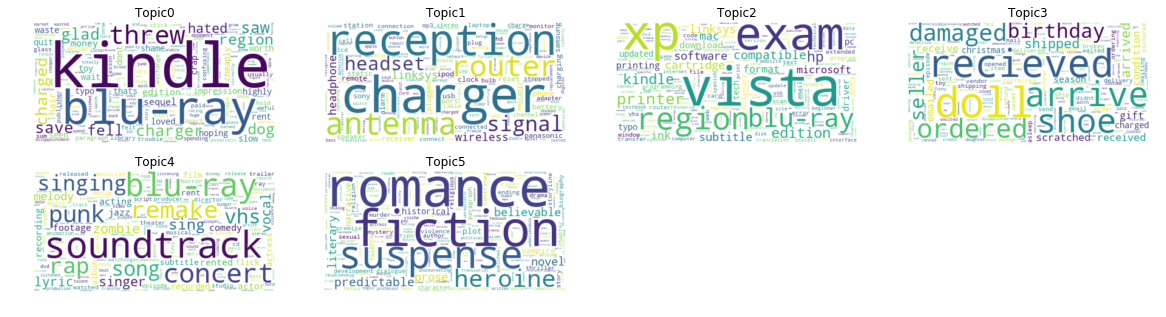

In [88]:
##visualize?
word_to_id = dict()
for i, v in enumerate(vocab_list):
    word_to_id[v] = i

limit = 24
n_col = 4
counter = 0

plt.figure(figsize=(20,16))
for ind in range(num_topics):

    if counter >= limit:
        break

    title_str = 'Topic{}'.format(ind)

    #pvals = mx.nd.softmax(W[:, ind]).asnumpy()
    pvals = mx.nd.softmax(mx.nd.array(W[:, ind])).asnumpy()

    word_freq = dict()
    for k in word_to_id.keys():
        i = word_to_id[k]
        word_freq[k] =pvals[i]

    wc = WordCloud(background_color='white').fit_words(word_freq)

    plt.subplot(limit // n_col, n_col, counter+1)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title_str)
    #plt.close()

    counter +=1

In [81]:


pd.DataFrame(vocab_list).to_csv('vocab.csv')

!aws s3 cp vocab.csv s3://nlp-awesome-sauce/dataset/ntm/



upload: ./vocab.csv to s3://nlp-awesome-sauce/dataset/ntm/vocab.csv


In [82]:


sagemaker.Session().delete_endpoint(ntm_predictor.endpoint)

